# Dev Data Slope Fitting

Note: this notebook uses py3.5 (for MNE)

In [1]:
%matplotlib qt
%matplotlib inline

In [2]:
# Custom imports
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import MNE
import mne

In [4]:
# Custom imports
from slf.core.db import SLFDB

In [5]:
# Get project database objects, and list of available subjects
db = SLFDB()
subjs = db.check_subjs()

In [17]:
# Set subject to run
cur_subj = subjs[1]

# Get subject data files
dat_f, ev_f, _ = db.get_subj_files(cur_subj)

In [26]:
# Get the resting data file - file 001
temp = [ef.split('_')[1] for ef in ev_f]
temp = [fn[-3:] for fn in temp]
f_ind = None
for i in range(len(temp)):
    if bb[i] == '001':
        f_ind = i
if not f_ind:
    print('No file found')

In [ ]:
# Set current data files to work on
f_ind = 1

# Get file file path for data file & associated event file
dat_f_name = db.gen_dat_path(cur_subj, dat_f[f_ind])
eve_f_name = db.gen_dat_path(cur_subj, ev_f[f_ind])

In [7]:
# Load data file
dat = np.loadtxt(dat_f_name, delimiter=',')

In [8]:
# Read default montage
montage = mne.channels.read_montage('GSN-HydroCel-129')
keep_chans = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 
              21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
              38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 57,
              58, 59, 60, 61, 62, 64, 65, 66, 67, 69, 70, 71, 72, 74, 75, 76, 77,
              78, 79, 80, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 95, 96, 97,
              98, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 114,
              115, 116, 117, 118, 120, 121, 122, 123, 124, 129])

# Fix zero based indexing (screw off matlab)
keep_chans = keep_chans - 1

# Get channel names to keep
kept_chans = list(np.array(montage.ch_names)[keep_chans])

In [9]:
# Settings for loading data
s_freq = 500

In [10]:
# Create the info structure needed by MNE
info = mne.create_info(kept_chans, s_freq, 'eeg')

# Create the MNE Raw data object
raw = mne.io.RawArray(dat, info)

Creating RawArray with float64 data, n_channels=111, n_times=209026
    Range : 0 ... 209025 =      0.000 ...   418.050 secs
Ready.


In [11]:
# Create a stim channel
stim_info = mne.create_info(['stim'], s_freq, 'stim')
stim_raw = mne.io.RawArray(np.zeros(shape=[1, len(raw._times)]), stim_info)

Creating RawArray with float64 data, n_channels=1, n_times=209026
    Range : 0 ... 209025 =      0.000 ...   418.050 secs
Ready.


In [12]:
# Add stim channel to data object
raw.add_channels([stim_raw], force_update_info=True)

<RawArray  |  None, n_channels x n_times : 112 x 209026 (418.1 sec), ~178.8 MB, data loaded>

In [13]:
# Load events from file

# Initialize headers and variable to store event info
headers = ['type', 'value', 'latency', 'duration', 'urevent']
evs = np.empty(shape=[0, 3])

# Load events from csv file
with open(eve_f_name, 'r') as csv_file:
    
    reader = csv.reader(csv_file)
    for row in reader:

        # Skip the empty rows
        if row == []: continue
        
        # Skip the header row, since there is one FOR EVERY DAMN EVENT. SERIOUSLY!?
        if row[0] == 'type': continue
        
        # Collect actual event data rows
        evs = np.vstack((evs, np.array([int(row[2]), 0, int(row[0])])))

# Add events to data object
raw.add_events(evs, stim_channel='stim')

# Check events
dat_evs = mne.find_events(raw)

12 events found
Events id: [20 30 90]


In [14]:
# Find flat channels and set them as bad
flat_chans = np.mean(raw._data[:111, :], axis=1) == 0
raw.info['bads'] = list(np.array(raw.ch_names[:111])[flat_chans])
print('Bad channels: ', raw.info['bads'])

Bad channels:  ['FidNz', 'E5', 'E11', 'E18', 'E22', 'E29']


## Resting EEG event descriptions

- 90: Start of the resting EEG paradigm
- 20: Eyes open start (20 seconds)
- 30: Eyes closed start (40 seconds)

^ There should be 5 of each EO and EC

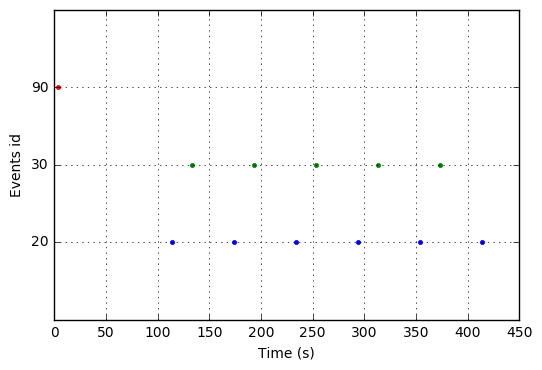

In [17]:
_ = mne.viz.plot_events(dat_evs, raw.info['sfreq'])

In [45]:
# Get good eeg channel indices
eeg_chans = mne.pick_types(raw.info, meg=False, eeg=True)

# Epoch resting eeg data events
eo_epochs = mne.Epochs(raw, events=dat_evs, event_id={'EO': 20},
                       tmin=5, tmax=15, baseline=None, picks=eeg_chans, 
                       add_eeg_ref=False, preload=True)
ec_epochs = mne.Epochs(raw, events=dat_evs, event_id={'EC': 30},
                       tmin=5, tmax= 35, baseline=None, picks=eeg_chans,
                       add_eeg_ref=False, preload=True)

6 matching events found
No baseline correction applied
0 projection items activated
Loading data for 6 events and 5001 original time points ...
1 bad epochs dropped
5 matching events found
No baseline correction applied
0 projection items activated
Loading data for 5 events and 15001 original time points ...
0 bad epochs dropped


In [93]:
# Calculate PSDs - EO Data
eo_psds, eo_freqs = mne.time_frequency.psd_welch(eo_epochs, fmin=1., fmax=40., n_fft=1000)

# Average PSDs for each channel across each rest block
eo_avg_psds = np.mean(eo_psds, axis=0)

Effective window size : 2.000 (s)


In [94]:
# Calculate PSDs - EC Data
ec_psds, ec_freqs = mne.time_frequency.psd_welch(ec_epochs, fmin=3., fmax=40., n_fft=1000)

# Average PSDs for each channel across each rest block
ec_avg_psds = np.mean(ec_psds, axis=0)

Effective window size : 2.000 (s)


In [95]:
# Get freq res of PSD
f_res = np.mean(np.diff(ec_freqs))

In [97]:
# Save out PSDs
np.savez(str(cur_subj) + 'ec_psds.npz', ec_freqs, ec_avg_psds, np.array(ec_epochs.ch_names))
np.savez(str(cur_subj) + 'eo_psds.npz', eo_freqs, eo_avg_psds, np.array(eo_epochs.ch_names))

### Extra / Old Stuff

In [58]:
# Plot a PSD
#plt.plot(np.log10(ec_freqs), np.log10(ec_avg_psd[0, :]))

In [59]:
# Plot some epoched data
#eo_epochs.plot(scalings=dict(eeg=10))

In [60]:
# Plot some raw data
#raw.plot(start=100, duration=2, scalings=dict(eeg=10))